# Optimized Meal Planning

## Define the model

Data

$$
\begin{aligned}
T, \text{the set of discrete time periods} \\
I, \text{the set of ingredients that are available} \\
N, \text{the set of nutrients that are tracked} \\
R, \text{the set of known recipes} \\
F_{ij}, \text{the amount of nutrient } j \text{ in a unit amount of ingredient } i,\ \forall i \in I,\ j \in N \\
S_{j}, \text{the amount of nutrient } j \text{ that is needed each week for a healthy diet} \\
C_{i}, \text{the unit cost of ingredient } i,\ \forall i \in I \\
V_{i}, \text{the unit volume of ingredient } i,\ \forall i \in I \\
Fr, \text{the max volume of the fridge} \\
Req_{il}, \text{the amount of ingredient i needed for recipe} \ l \ \forall i \in I, l \in R \\
MAX, \text{the maximum number of recipes that can be made in a week} (tentative)
\end{aligned}
$$


Decision variables:
- $x_{ik}$, the amount of ingredient i bought in week k, $\forall i \in I, k \in T$
- $y_{lk}$, the amount of recipe $l$ to make in week k, $\forall l \in R, k \in T$
- $z_{ik}$, the amount of ingredient i to store in the fridge in week k, $\forall i \in I, k \in T$

Linear Program:
\begin{align}
\min \sum_{k \in T} \sum_{i \in I} x_{ik} * C_i \\
\text{s.t. } \sum_{l \in R} \sum_{i \in I} y_{lk} * Req_{il} * F_{ij} \geq S_{j}, \forall k \in T, j \in N \\
\sum_{i \in I} z_{ik} * V_{i} \leq Fr, \forall k \in T \\
z_{i0} = 0, \forall i \in I \\
x_{ik} + z_{i,k-1} = \sum_{l \in R} y_{lk} * Req_{il} + z_{ik}, \forall k \in T, i \in I \\
\sum_{l \in R} y_{lk} \leq MAX, \forall k \in T \\
y_{lk}, x_{ik}, z_{ik} \geq 0, \forall i \in I, k \in T
\end{align}

- The first constraint ensures there are enough nutrients
- The second constraint ensures that the fridge is not overfilled
- The third constraint sets the intial amount of food to 0
- The fourth constraint ensures that the amount of each ingredient being consumed is balanced by the amount being bought
- The fifth constraint limits the amount of recipes made in a week (i.e. only 7 recipes worth of recipes being made)

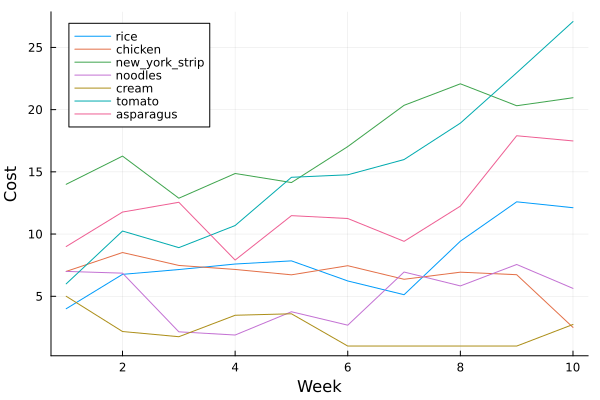

10×7 Named Matrix{Float64}
Ingredients ╲ Week │           rice  …       asparagus
───────────────────┼──────────────────────────────────
1                  │           -0.0  …            -0.0
2                  │            0.0                0.0
3                  │            0.0                0.0
4                  │            0.0                0.0
5                  │            0.0                0.0
6                  │            0.0                0.0
7                  │            0.0                0.0
8                  │            0.0                0.0
9                  │            0.0                0.0
10                 │            0.0  …             0.0

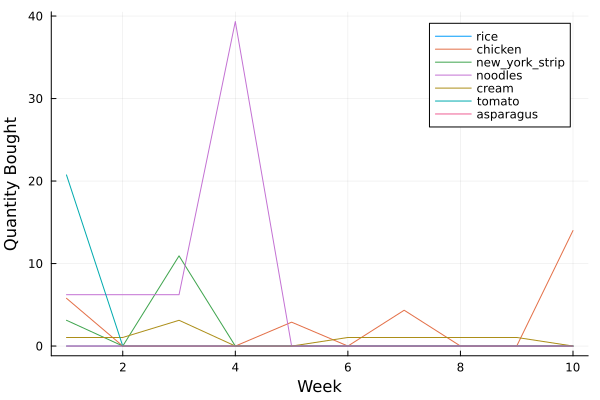


Recipes cooked per week


10×4 Named Matrix{Float64}
Recipes ╲ Week │ steak_rice_asparagus  …         steak_alfredo
───────────────┼──────────────────────────────────────────────
1              │                  0.0  …              0.520635
2              │                 -0.0                 0.520635
3              │                 -0.0                 0.520635
4              │                  0.0                 0.520635
5              │                  0.0                 0.520635
6              │                  0.0                 0.520635
7              │                  0.0                 0.520635
8              │                  0.0                 0.520635
9              │                  0.0                 0.520635
10             │                 -0.0  …                   0.0

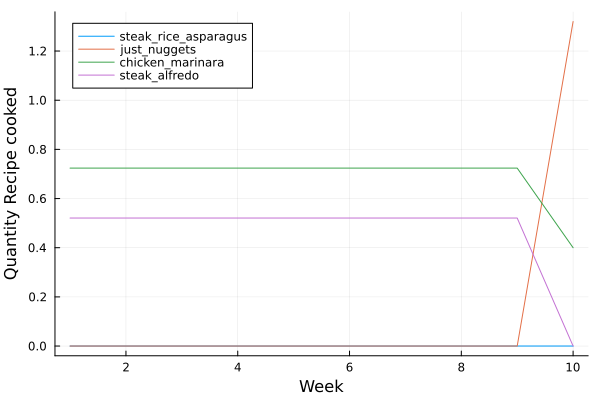


622.5793968944901


In [22]:
# for now leave out multi-period planning and general form - too complex
using Random, NamedArrays, Plots

T_end = 10
T = 1:T_end
FR_CAP = 100

#Data 2:
Random.seed!(300)
I = [:rice, :chicken, :new_york_strip, :noodles, :cream, :tomato, :asparagus]

N = [:calories, :protein, :fiber, :carbs, :fat, :vitamins, :minerals]

R = [:steak_rice_asparagus, :just_nuggets, :chicken_marinara, :steak_alfredo]
Req = NamedArray([5 0 3 0 0 0 3; 0 10 0 0 0 0 0; 0 2 0 5 0 3 0; 0 0 3 5 2 0 0], (R, I), ("Recipes", "Ingredients")) 

F = NamedArray([300 0 .5 30 0 0 2;
        200 5 .5 9 12 1 3;
        400 20 0 0 3 1 3;
        300 5 1 25 1 1 1;
        200 10 0 1 18 2 .5;
        100 0 5 5 0 4 3;
        150 0 8 5 0 5 2
        ], (I, N), ("Ingredients", "Nutrients"))

S = NamedArray([2000, 80, 15, 100, 10, 20, 20], N, "Nutrient Requirements")

Cinit = []
C = NamedArray(zeros(Float64, length(T), length(I)), (T, I), ("Week", "Ingredients"))
V = NamedArray([.5, .5, 1, 2, .5, .5, 1], I, "Volume")

for i in 1:length(I)
    C[1, i] = length(String(I[i]))
end

for t in 2:length(T)
    for i in 1:length(I)
        C[t, i] = C[t - 1, i] + 2 * Random.randn() + .05 * C[t - 1, i]
        if C[t, i] <= 1
            C[t, i] = 1.0
        end
    end
end


# make the model
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)

@variable(m, x[T, I] >= 0)
@variable(m, y[T, R] >= 0)
@variable(m, z[T, I] >= 0)

# Indexing Guide:
#
# t - time, i - ingredient, r - recipe, n - nutrient
# x[t, i], y[t, r], Req[r, i], F[i, n]

@constraint(m, nutr_satisfied[n in N, t in T],
    sum(y[t, r] * sum(Req[r, i] * F[i, n] for i in I) for r in R) >= S[n])

@constraint(m, fridge_capacity[t in T], sum( (x[t, i] * V[i])  for i in I ) <= FR_CAP)

@constraint(m, first_ingredient_bal[i in I], x[1, i] == sum( y[1,r] * Req[r,i] for r in R) + z[1, i])

@constraint(m, ingredient_bal[t in 2:T_end, i in I], x[t, i] + z[t-1, i] == sum( y[t,r] * Req[r,i] for r in R) + z[t, i])

@objective(m, Min, sum( x[t, i] * C[t, i] for i in I, t in T ))

set_silent(m)
optimize!(m)

ingredient_values = NamedArray( [ (value(x[t, i])) for t in T, i in I ], (T, I), ("Ingredients", "Week"))
recipe_values = NamedArray( [ (value(y[t,r])) for t in T, r in R ], (T, R), ("Recipes", "Week"))

p1 = plot(1:10, C, xlabel="Week", ylabel="Cost" , label=permutedims(String.(I)))
display(p1)
println()

display(ingredient_values)
println()

p2 = plot(1:10, ingredient_values, xlabel="Week", ylabel="Quantity Bought" , label=permutedims(String.(I)))
display(p2)
println()

println("Recipes cooked per week")
display(recipe_values)
println()

p3 = plot(1:10, recipe_values, xlabel="Week", ylabel="Quantity Recipe cooked" , label=permutedims(String.(R)))
display(p3)
println()


# println("Buy ingredients ", value.(x))
# println("Make recipes ", value.(y))
println("Total cost ", objective_value(m))

In [9]:
#using DataFrames, CSV
#df = CSV.read("stigler.csv",DataFrame,delim=',')